# Compression Anonymity

This notebook explores several avenues of using compression and common compression schemes to provide anonymity and privacy. First, we'll write a simple implementation of Huffman encoding, but make it generic enough so that it can be tweaked to provide privacy instead of compression.

Huffman compression is the first example of compression for anonymity: it has a ready analogue in the form of $k$-anonymity <cite data-cite="2201627/S5ZJQFX5"></cite>. By truncating the output of the Huffman compression, rows which occur fewer than $k$ times are not specified: instead, a prefix (which could correspond to some $n$ rows, $n \geq k$) is provided.

Taken from a different perspective, we build a Huffman tree from the rows in our database. Then, for each value in the database, we walk down the tree from root to the corresponding leaf, stopping if we hit a node that contains fewer than $k$ entries. Then, we output the summary of values at that point.

This general procedure forms the basis for several of the anonymization algorithms. First, we will write the Huffman algorithm in a way generic enough that it can be tweaked to provide privacy instead of 

# Preliminaries

Before writing any code for privacy, we'll need the basic data structures and building blocks we're going to use throughout this notebook to write the compression algorithms.

## Utility Functions

In [1]:
:ext ScopedTypeVariables

import Data.Coerce
import Data.Semigroup (Semigroup((<>)))

combineBy :: (Coercible b a, Semigroup b) => (a -> b) -> a -> a -> a
combineBy (_ :: a -> b) = coerce ((<>) :: b -> b -> b)

## A Frequency Tree

This is the Huffman Tree we'll use for both the encoding and anonymization algorithms.

In [2]:
:ext DeriveFoldable

import Data.Semigroup.Foldable (Foldable1(foldMap1))
import Data.Semigroup          ((<>))

data Tree a
    = Leaf { size :: {-# UNPACK #-} !Int
           , val :: a }
    | Node { size :: {-# UNPACK #-} !Int
           , lchild :: Tree a
           , rchild :: Tree a }
    deriving Foldable

instance Foldable1 Tree where
    foldMap1 f (Leaf _ x) = f x
    foldMap1 f (Node _ l r) = foldMap1 f l <> foldMap1 f r

We can draw the tree, with the counts of subtrees at each node:

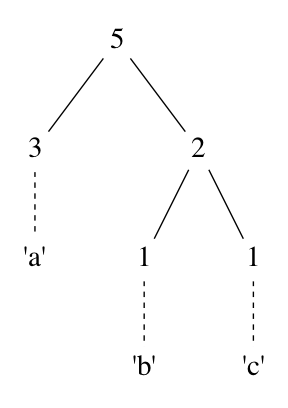

In [3]:
:ext FlexibleContexts

import           Diagrams.TwoD.Layout.Tree (renderTree',symmLayout)
import           Diagrams.Prelude          (text,fontSizeL,circle,fc,lc
                                           ,white,pad,centerXY,(~~),(#)
                                           ,dashingG)
import           IHaskell.Display          (IHaskellDisplay(display))
import qualified Data.Tree                 as Rose
import           Data.Semigroup            ((<>))

instance Show a => IHaskellDisplay (Tree a) where
    display = display . diagram . drawTree . toTree
      where
        toTree (Leaf i x)
            = Rose.Node (True,show i) [Rose.Node (False,show x) []]
        toTree (Node i l r)
            = Rose.Node (True,show i) [toTree l, toTree r]
        renderNode n = text n # fontSizeL 0.2
                    <> circle 0.2 # fc white # lc white
        renderBranch (_,l) (vr,r)
          | fst vr = l ~~ r
          | otherwise = l ~~ r 
                      # dashingG [0.05, 0.05] 0
        drawTree
            = pad 1.1
            . centerXY
            . renderTree' (renderNode . snd) renderBranch
            . symmLayout

Node 5 (Leaf 3 'a') (Node 2 (Leaf 1 'b') (Leaf 1 'c'))

Then, we'll need some machinery for translating between codes and trees.

In [4]:
import           Data.Map.Strict (Map)
import qualified Data.Map.Strict as Map
import           Data.Semigroup  (Semigroup((<>)))

type Code = [Bool]

foldMapWithCode :: Semigroup m => (Code -> a -> m) -> Tree a -> m
foldMapWithCode f (Leaf _ x) = f [] x
foldMapWithCode f (Node _ xs ys)
    =  foldMapWithCode (f . (:) False) xs 
    <> foldMapWithCode (f . (:) True) ys 

codeBook :: Ord a => Tree a -> Map a Code
codeBook = foldMapWithCode (flip Map.singleton)

## A Priority Queue

A pairing heap <cite data-cite="2201627/9H95638W"></cite> is simple to implement, and works well as a priority queue. Both the `<>` and `insertHeap` functions below are amortized $\mathcal{O}(1)$, and `minView` is amortized $\mathcal{O}(\log n)$.

In [5]:
import Data.Semigroup (Semigroup((<>)))

data Heap a = Heap {-# UNPACK #-} !Int !a [Heap a]

instance Semigroup (Heap a) where
    Heap i x xs <> Heap j y ys
      | i <= j = Heap i x (Heap j y ys : xs)
      | otherwise = Heap j y (Heap i x xs : ys)

minView :: Heap a -> (Int, a, Maybe (Heap a))
minView (Heap i x xs) = (i, x, case xs of
    [] -> Nothing
    (y:ys) -> Just (mergeHeaps y ys))
  where
    mergeHeaps t []          = t
    mergeHeaps t1 [t2]       = t1 <> t2
    mergeHeaps t1 (t2:t3:ts) = (t1 <> t2) <> mergeHeaps t3 ts

insertHeap :: Int -> a -> Heap a -> Heap a
insertHeap i x (Heap j y ys)
  | i <= j = Heap i x [Heap j y ys]
  | otherwise = Heap j y (Heap i x [] : ys)

## A Frequency Table

We'll be using Haskell's standard `Map` type, which has $\mathcal{O}(\log n)$ update, delete, etc. Building a frequency table is therefore $\mathcal{O}(n \log n)$.

In [ ]:
import           Data.Map.Strict (Map)
import qualified Data.Map.Strict as Map

import           Data.Foldable   (Foldable(foldMap,foldl'))
import           Data.Semigroup  (Semigroup(..))
import           Data.Coerce

newtype Frequencies a
    = Frequencies
    { getFrequencies :: Map a Int
    }

instance Ord a => Semigroup (Frequencies a) where
    (<>) = Map.unionWith (+) `ala` getFrequencies

instance Ord a => Monoid (Frequencies a) where
    mempty = Frequencies Map.empty
    mappend = (<>)

buildFrequencies :: (Ord a, Foldable f) => f a -> Frequencies a
buildFrequencies = foldMap (Frequencies . flip Map.singleton 1)

instance Foldable Frequencies where
    foldMap f (Frequencies xs) =
        Map.foldMapWithKey (rep . f) xs
      where
        rep x 1 = x
        rep x n
          | even n = mappend y y
          | otherwise = mappend x (mappend y y)
          where y = rep x (n `div` 2)

We can plot the contents of a frequency table using a histogram.

In [ ]:
import Graphics.Rendering.Chart (layout_x_axis,laxis_generate
                                ,layout_y_axis,toRenderable,autoIndexAxis
                                ,laxis_title,layout_plots,plotBars
                                ,plot_bars_values,addIndexes
                                ,plot_bars_item_styles,fill_color)
import Data.Colour              (withOpacity)
import Data.Colour.Names        (cornflowerblue)
import Data.Default.Class       (def)
import Control.Lens             ((.~),_1,each)
import IHaskell.Display         (IHaskellDisplay(display))

instance Show a => IHaskellDisplay (Frequencies a) where
    display (Frequencies freqs)
        = display
        $ toRenderable
        $ layout_x_axis.laxis_generate .~ autoIndexAxis keys
        $ layout_y_axis.laxis_title .~ "Frequency"
        $ layout_plots .~ [ plotBars
                          $ plot_bars_values .~ addIndexes vals
                          $ plot_bars_item_styles.each._1.fill_color .~
                                cornflowerblue `withOpacity` 0.3
                          $ def ]
        $ def
      where
        (keys,vals) = unzip [ (show k, [v]) | (k,v) <- Map.toList freqs ]

:opt svg

buildFrequencies "this is an example of a frequency table"

# Building the Huffman Tree

In [ ]:
import           Data.Maybe       (fromJust)
import           Data.Semigroup   (Option(..))
import           Data.Map.Strict  (Map)
import qualified Data.Map.Strict  as Map
import           IHaskell.Display (Display(..),html)
import           Data.Bool        (bool)

buildHuffman :: Heap (Tree a) -> Tree a
buildHuffman hp = case minView hp of
    (_,x,Nothing) -> x
    (i,x,Just xs) -> case minView xs of
        (j,y,Nothing) -> Node (i+j) x y
        (j,y,Just ys) ->
            buildHuffman (insertHeap (i+j) (Node (i+j) x y) ys)

buildHeap :: Frequencies a -> Heap (Tree a)
buildHeap
    = fromJust
    . getOption
    . Map.foldMapWithKey (\v i -> Option (Just (Heap i (Leaf i v) [])))
    . getFrequencies

huffmanTree :: Ord a => [a] -> Tree a
huffmanTree = buildHuffman . buildHeap . buildFrequencies

tree = huffmanTree "this is an example of a huffman tree"
tree

data HuffmanTable a
    = HuffmanTable
    { huffmanTableVals :: [a]
    , huffmanTableCode :: [[Bool]]
    }

codeBook :: Ord a => Tree a -> Map a [Bool]
codeBook = go []
  where
    go k (Leaf _ x) = Map.singleton x (reverse k)
    go k (Node _ l r) = Map.union (go (False:k) l) (go (True:k) r)

buildHuffmanTable :: Ord a => Tree a -> [a] -> HuffmanTable a
buildHuffmanTable tr xs = HuffmanTable xs (map (mp Map.!) xs)
  where
    mp = codeBook tr

instance Show a => IHaskellDisplay (HuffmanTable a) where
    display (HuffmanTable xs ys) = pure (Display [html go])
      where
        go
            = unlines $
            [ "<table>"
            , "<tr><th>Original</th><th>Code</th></tr>" ] ++
            zipWith tr xs ys ++
            [ "</table>" ]
        tr orig code
            = concat 
            [ "<tr><td style=\"text-align: center;\">"
            , show orig
            , "</td><td><pre style=\"text-align: left;\">"
            , map (bool '0' '1') code
            , "</pre></td></tr>" ]

buildHuffmanTable tree "example"

# Using the Tree for Anonymity

To use the tree to $k$-anonymize some data, we will walk down until either of a node's children has fewer than $k$ members. Then, that node will be represented by a *summary* of all of its elements.

First, for data, let's use ages:

In [ ]:
default (Int,Double)

ages :: [Int]
ages = [5,15,19,22,25,33,33,39,31,44,41,42,48,55,59,70]

huffmanTree ages

And to display the ages, a histogram with buckets:

In [ ]:
import Graphics.Rendering.Chart                (PlotValue,Renderable
                                               ,Layout,toRenderable
                                               ,fill_color)
import Graphics.Rendering.Chart.Plot.Histogram (histToPlot
                                               ,plot_hist_values
                                               ,plot_hist_bins
                                               ,plot_hist_range
                                               ,plot_hist_fill_style)
import Data.Colour                             (withOpacity)
import Data.Colour.Names                       (cornflowerblue)
import Data.Default.Class                      (def)
import Control.Lens                            ((.~))

histogram :: (Ord a, RealFrac a, PlotValue a)
          => a -> a -> [a] -> Renderable ()
histogram binSize lowerBound values =
    toRenderable
  $ layout_plots .~ [ histToPlot 
                    $ plot_hist_values .~ values
                    $ plot_hist_bins .~ bins
                    $ plot_hist_range .~
                        Just (lowerBound
                             ,lowerBound + fromIntegral bins * binSize)
                    $ plot_hist_fill_style . fill_color .~
                        cornflowerblue `withOpacity` 0.3
                    $ def ]
  $ (def :: PlotValue a => Layout a Int)
  where
    bins = ceiling ((maximum values - lowerBound) / binSize)

histogram 10 0 (map toEnum ages)

To summarize ages, we'll also need a range type:

In [ ]:
import Data.Semigroup      (Semigroup(..))
import Control.Applicative (liftA2)
import Text.Printf         (printf,PrintfArg)
import Data.Maybe          (fromMaybe,fromJust)

data Range a
    = Range
    { lowerBound :: Maybe a
    , upperBound :: Maybe a
    } deriving (Eq,Ord)

instance (Ord a, Enum a, PrintfArg a, Bounded a) => Show (Range a) where
    show (Range (Just l) (Just u))
      | succ l == u = printf "%v" l
      | l >= u = "∅"
    show (Range l (Just u)) = printf "[%v,%v)" (fromMaybe minBound l) u
    show (Range l Nothing)
      | l == Just maxBound = printf "%v" (maxBound `asTypeOf` fromJust l)
      | otherwise =
          printf
              "[%v,%v]"
              (fromMaybe minBound l)
              (maxBound `asTypeOf` fromJust l)

instance Ord a => Semigroup (Range a) where
    Range xl xu <> Range yl yu =
        Range
            (liftA2 min xl yl)
            (liftA2 max xu yu)

singletonRange :: (Enum a, Bounded a, Eq a) => a -> Range a
singletonRange x
  | x == maxBound = Range (Just x) Nothing
  | otherwise = Range (Just x) (Just (succ x))

Finally, we can draw the tree in its private form.

In [ ]:
import           Diagrams.TwoD.Layout.Tree (renderTree',symmLayout)
import           Diagrams.Prelude          (text,fontSizeL,circle,fc
                                           ,lc,white,pad,centerXY,(#)
                                           ,(~~),opacity,bg)
import           IHaskell.Display          (IHaskellDisplay(display)
                                           ,latex,Display(ManyDisplay))
import qualified Data.Tree                 as Rose
import           Data.Semigroup            (Semigroup(..))
import           Data.Semigroup.Foldable   (foldMap1)

data PrivateHuffman a b
    = PrivateHuffman
    { kval :: Int
    , generalize :: a -> b
    , tree :: Tree a
    }

instance (Show a, Semigroup b, Show b)
        => IHaskellDisplay (PrivateHuffman a b) where
    display (PrivateHuffman k f tr) = 
        fmap (Display [ latex ("$k = " ++ show k ++ "$") ] <>)
                    (display $ diagram $ bg white $ drawTree $ toTree tr)
      where
        toTree (Leaf i x) =
            Rose.Node (i < k, show i) [Rose.Node (i < k, show x) []]
        toTree (Node i l r)
          | size l >= k && size r >= k =
               Rose.Node (i < k, show i) [toTree l, toTree r]
          | otherwise =
              Rose.Node (i < k, show i)
                  [ Rose.Node (i < k, show (foldMap1 f l <> foldMap1 f r))
                        [ toHiddenTree l, toHiddenTree r ] ]
                        
        toHiddenTree (Node i l r) =
            Rose.Node (True,show i)
                [toHiddenTree l, toHiddenTree r]
        toHiddenTree (Leaf i x) =
            Rose.Node (True,show i)
                [Rose.Node (True, show x) []]

        drawTree
            = pad 1.1
            . centerXY
            . renderTree'
                (\(b,n) -> text n # fontSizeL 0.2 # maybeOp b
                        <> circle 0.2 # fc white # lc white)
                (\((lb,_),ll) ((rb,_),rr) -> maybeOp (lb||rb) (ll ~~ rr))
            . symmLayout
        maybeOp False = id
        maybeOp True  = opacity 0.5

Using this, we can see the immediate problem with Huffman encoding for anonymity:

In [ ]:
k2ages = PrivateHuffman 2 singletonRange
    (buildHuffman (buildHeap (buildFrequencies ages)))

k2ages

Ages are grouped together with values that are unrelated, yielding unsatisfactory generalizations. The anonymization produced is as follows:

In [ ]:
import qualified Data.Map.Strict         as Map
import           Data.Semigroup          (Semigroup(..))
import           Data.Semigroup.Foldable (foldMap1)
import           Data.Foldable           (foldl')
import           IHaskell.Display        (IHaskellDisplay(display)
                                         ,html,Display)
import           Text.Printf             (printf)

newtype AnonTable a b
    = AnonTable
    { getAnonTable :: [(a,b)]
    }

buildAnonTable :: (Ord a, Semigroup b)
               => PrivateHuffman a b -> [a] -> AnonTable a b
buildAnonTable (PrivateHuffman k f xs)
    = AnonTable . map (\x -> (x, m Map.! x))
  where
    m = go xs
    go (Leaf _ x) = Map.singleton x (f x)
    go nd@(Node i l r)
      | size l >= k && size r >= k = go l <> go r
      | otherwise =
          foldl' (\mp v -> Map.insert v summary mp) Map.empty nd
      where summary = foldMap1 f nd

instance (Show a, Show b) => IHaskellDisplay (AnonTable a b) where
    display (AnonTable xs) = pure (Display [html (go xs)])
      where
        go tb
            = unlines
            $ "<table>"
            : "<tr><th>Original</th><th>Anonymized</th></tr>"
            : map (uncurry row) tb ++
            [ "</table>" ]
        row orig anon
            = concat
            [ "<tr><td style=\"text-align: center;\">"
            , show orig
            , "</td><td style=\"text-align: center;\">"
            , show anon
            , "</td></tr>" ]

buildAnonTable k2ages ages

Better generalizations can be achieved by building an *alphabetic* Huffman tree <cite data-cite="2201627/M35JL7I9"></cite>.

In [ ]:
import           Control.Monad.State
import qualified Data.Map.Strict     as Map
import           Data.Foldable       (Foldable(..))

buildAlphHuffman :: Frequencies a -> Tree a
buildAlphHuffman xs = evalState (go c) (Map.toList (getFrequencies xs))
  where
    c = length xs
    go n = do
      (x,i) <- gets head
      if i >= n
        then do
          modify tail
          pure (Leaf i x)
        else do
          let m = n `div` 2
          ls <- go m
          rs <- go (n - size ls)
          pure (Node (size ls + size rs) ls rs)

alphHuffmanTree :: Ord a => [a] -> Tree a
alphHuffmanTree = buildAlphHuffman . buildFrequencies

k2agesAlph =
    PrivateHuffman 2 singletonRange (alphHuffmanTree ages)
k2agesAlph
buildAnonTable k2agesAlph ages

# Arithmetic Coding for Privacy

Arithmetic coding compresses data by encoding successively smaller and smaller intervals. For our purposes, it has two properties which are desirable:

* It is a streaming algorithm, able to output the encoding for an input symbol once it has been received.
* It parameterizes the notion of a "model": for compression, this allows intelligent prediction of things like "a u is likely to come after a q" (when compressing English text). Commonly, it facilitates the building of a frequency table on the fly. For our purposes, it will both build the frequency table on-the-fly, and potentially allow us to cluster similar data together.

In order to use the algorithm for privacy, we will first emit a sequence of intervals, instead of a single number. This removes the capacity for compression. For instance, for the letters $a,b,c$, the following might be emitted:

$$\frac{1}{3},\frac{1}{3},\frac{1}{3}$$

Secondly, we will use a model that builds a cumulative frequency table on the fly (e.g. with a Fenwick tree). This widens the interval for more frequently occurring symbols.

Thirdly, we will truncate the output of the representation of each interval. In other words, we will widen every interval. The amount we widen by will be the minimum amount to make the interval larger than $\frac{k}{n}$ where $n$ is the number of symbols seen so far.

Finally, we will decompress as we compress, translating the intervals back into the values of the domain we are anonymizing. Because we have truncated the interval, it may span more than one value in our model. This is desired: it will happen only when $k$ is satisfied only through generalization.

As a simple way to demonstrate the algorithm, we will use a perfect binary tree to count the cumulative frequencies:

In [ ]:
:ext TypeSynonymInstances
:ext FlexibleInstances

import           Data.Bits
import           IHaskell.Display          (IHaskellDisplay(display))
import qualified Data.Tree                 as Rose
import           Diagrams.TwoD.Layout.Tree (renderTree,symmLayout)
import           Diagrams.Prelude          (text,fontSizeL,circle,fc
                                           ,lc,white,pad,centerXY,(#)
                                           ,(~~))
import           Data.Maybe                (catMaybes,fromJust)

data Nested a
    = Perfect !a
    | Nest !(Nested (Branch a))

type Perfect = Nested ()

foldPerfect :: (Word -> b -> Word -> b -> b) -> b -> Perfect -> b
foldPerfect f = go f . const
  where
    go :: (Word -> b -> Word -> b -> b) -> (a -> b) -> Nested a -> b
    go _ b (Perfect x) = b x
    go f b (Nest t) = go f (\(Branch ls l rs r) -> f ls (b l) rs (b r)) t

data Branch a =
    Branch {-# UNPACK #-} !Word
           !a
           {-# UNPACK #-} !Word
           !a

data Span = Span {-# UNPACK #-} !Word {-# UNPACK #-} !Word

instance Show Span where
    showsPrec n (Span l 0) = showsPrec n l
    showsPrec _ (Span l o)
        = showChar '['
        . shows (shiftL l (fromEnum o))
        . showChar ','
        . shows (shiftL (l + 1) (fromEnum o))
        . showChar ')'

makePerfect :: Word -> Perfect
makePerfect = mk ()
  where
    mk :: a -> Word -> Nested a
    mk x 0 = Perfect x
    mk x m = Nest (mk (Branch 0 x 0 x) (m - 1))

incr :: Word -> Perfect -> Perfect
incr i tr = go i 0 tr id
  where
    go :: Word -> Word -> Nested a -> (a -> a) -> Nested a
    go _ _ (Perfect x) c = Perfect (c x)
    go i p (Nest t) c =
        Nest $
        go i (p + 1) t $
            \(Branch sl l sr r) ->
              if testBit i (fromEnum p)
                then Branch sl l (sr + 1) (c r)
                else Branch (sl + 1) (c l) sr r

instance IHaskellDisplay Perfect where
    display = display
            . diagram
            . drawTree
            . res
            . foldPerfect toTree []
      where
        toTree x l y r = [Rose.Node x l, Rose.Node y r]
        res xs = Rose.Node (sum (map Rose.rootLabel xs)) xs
        drawTree
            = pad 1.1
            . centerXY
            . renderTree
                (\n -> text (show n) # fontSizeL 0.2
                    <> circle 0.2 # fc white # lc white)
                (~~)
            . symmLayout
                
foldr incr (makePerfect 3) [0,3,3,2,6]

Then, we can write a function that looks up an item in the tree *up until* the point where $k$ is no longer satisfied:

In [ ]:
follow :: Int -> Word -> Perfect -> Span
follow k' i tr = foldPerfect go Span tr 0 k
  where
    k = toEnum k'
    go sl lt sr rt l p
      | sl < k || sr < k = Span l p
      | testBit i (fromEnum p - 1) = rt (shiftL l 1 .|. 1) (p - 1)
      | otherwise = lt (shiftL l 1) (p - 1)

The advantage of this approach is that it maintains $k$-anonymity incrementally. Take, for instance, this small list of values between $0$ and $4$:

In [ ]:
smallVals = [1,2,1,3,2,0,1,0,3]

import Data.Traversable (mapAccumL)
import Data.List        (inits)

incrementalAnon :: Int -> Word -> [Word] -> [[Span]]
incrementalAnon k sz xs
    = snd 
    $ mapAccumL
        anon
        (makePerfect sz)
        (zip xs (tail (inits xs)))
  where
    anon tr (v,vs) = (i,traverse (follow k) vs i)
      where
        i = incr v tr

mapM_ print (incrementalAnon 2 2 [1,2,1,3,2,0,1,0,3])

# Incremental Anonymity

Incrementally anonymizing a database can potentially leak private data <cite data-cite="2201627/HWXFFBRT"></cite>. For instance, take the following values:

In [ ]:
incrementalTree = PrivateHuffman 2 singletonRange (alphHuffmanTree [1..5])
incrementalTable = buildAnonTable incrementalTree [1..5]
incrementalTable

If another $3$ is added to the database:

In [ ]:
nextTree = PrivateHuffman 2 singletonRange (alphHuffmanTree [1,2,3,4,5,3])
nextTable = buildAnonTable nextTree [1,2,3,4,5,3]
nextTable

If both of these anonymizations are released, we could take their row-wise intersection, thereby revealing much more information than we intended.

In [ ]:
import Data.Function  (on)
import Data.Semigroup (Max(..),Min(..),Option(..),(<>))

intersection :: Ord a => Range a -> Range a -> Range a
intersection (Range lx ux) (Range ly uy)
    = Range
        (((<>) `ala` (Option . fmap Max)) lx ly)
        (((<>) `ala` (Option . fmap Min)) ux uy)

AnonTable (zip [1..]
          ((zipWith (intersection `on` snd) `on` getAnonTable)
          incrementalTable nextTable))

The solution might seem simple: just don't change the anonymization of previous entries. But this is actually sub-optimal, leaving earlier more conservative than they need to be.

The problem is related to *tree-balancing*. For search trees, we want to balance to reduce search cost, but reduce the frequency of balancing to reduce insertion cost: here, we want to balance to increase information gain, but reduce frequency of balancing to avoid revealing private internal structure.

It's worth noting that we're not concerned with the overall frequency of balances, rather the rebalancing per release. After all, if we only release one copy of the anonymized data set, we need not be concerned with incremental privacy at all.

# Generalized Balance

In the previous section, we saw that we could generalize the "cost of rebalancing" to describe incremental anonymity. Other notions from the theory of search trees can be generalized similarly, in particular *balance*.

One generalization applies to $l$-diversity <cite data-cite="2201627/E9354EJL"></cite>.

Let's take a database with a sensitive row, perhaps voting preference:

In [ ]:
import Control.Arrow ((***))
import Text.Printf   (PrintfArg(..),formatChar)

data VotingPref
    = D
    | R
    deriving (Show,Eq,Ord,Enum,Bounded)

instance PrintfArg VotingPref where
    formatArg D = formatChar 'D'
    formatArg R = formatChar 'R'

agesAndVotes = zip ages [D,R,D,D,R,D,R,R,R,R,D,D,R,R,D,D]
agesAndVotesTree = PrivateHuffman 2
    (singletonRange *** singletonRange) (alphHuffmanTree agesAndVotes)
agesAndVotesTable = buildAnonTable agesAndVotesTree agesAndVotes
agesAndVotesTree
agesAndVotesTable

As you can see, while $k$-anonymity has indeed been preserved, most rows in the table have had their voting preference revealed. To counteract that, we can balance the voting preference when building the tree: however, this ups the complexity of the procedure.

# Randomization

Providing an equivalence class for each $k$-anonymous value is problematic in 2 ways:

* It allows an adversary to intersect the members of this class with future releases, revealing more information that originally intended.
* It doesn't provide distribution information on the members of the class.

While we could remedy the second point by providing a histogram instead of a set, but that would exacerbate the problem of the first.

Instead, we can randomize the output from the tree traversal, providing a concrete value that may have noise added in the output. This will allow us to output a representative table, with the distributions similar to the private table, but also it will hide the equivalence groupings we use in the tree, allowing us to aggressively rebalance when necessary.

This concept maps on to group differential privacy.

The idea is as follows: for every row, we're going to choose one bit to replace with a fairly chosen representative of that bit, based on the histogram of the table. The $\epsilon$ (of $\epsilon$-differential privacy) is given by the difference in size of the two branches, over the sum in the size of the two branches. For instance, in the following table:

In [ ]:
table = "aabbbcdee"

simpleTree = huffmanTree table
simpleTree
buildHuffmanTable simpleTree table

Replacing the last bit in the first 'b' with a histogram would provide:

$$\epsilon = \frac{3-2}{3+2}$$

$\epsilon$-differential privacy. However, since it's from a subset of the database of size $5$, there are going to be $5$ differentially private queries on that subset. So, it would actually only provide:

$$\epsilon = \frac{1}{5^2}$$

$\epsilon$-differential privacy.

For every row in the database, we can replace one bit with its histogram representation: the equation above gives the privacy provided by replacing that bit. Obviously, the privacy provided by replacing later bits is much greater than that of earlier.

In [ ]:
import Data.Ratio    ((%))
import Data.Function (on)

diffPrivacy :: Tree a -> Rational
diffPrivacy (Node i l r)
    = ((%) `on` toEnum) (abs (size l - size r)) (i * i)
diffPrivacy (Leaf _ _) = 0

To use this for releasing private information, we will first need to have a way to generate a random bit from a histogram:

In [ ]:
import System.Random       (RandomGen, randomR, getStdRandom)
import Control.Monad.State (StateT, state, runState, runStateT)
import Data.Bool           (bool)

choose :: (RandomGen g, Applicative m) => Int -> Int -> StateT g m Bool
choose f t = StateT (\g -> case randomR (1, f+t) g of
  (n,g') -> pure (f<n,g'))

getStdRandom (runState (replicateM 20 (bool '0' '1' <$> choose 1 1)))

Then, we'll need to be able to randomly choose an item from a histogram (represented as a tree):

In [ ]:
select :: (RandomGen g, Monad m) => Tree a -> StateT g m a
select (Leaf _ x) = pure x
select (Node _ l r) = choose (size l) (size r)
                  >>= bool (select l) (select r)

In [ ]:
import Data.Bool (bool)

subtrees :: [Bool] -> Tree a -> [Tree a]
subtrees = foldr f b where
  b = (:[])
  f side acc tr = tr : case tr of
    Leaf _ _ -> []
    Node _ l r -> acc (bool l r side)

last :: Foldable f => f a -> Maybe a
last = foldl (const Just) Nothing

diffAnonymize :: RandomGen g
              => Rational
              -> [Bool]
              -> Tree a
              -> Maybe (State g a)
diffAnonymize eps xs
    = fmap select
    . last
    . filter (\st -> diffPrivacy st > eps)
    . subtrees xs

randAnon :: (Ord a, RandomGen g) => Rational -> [a] -> Maybe (State g [a])
randAnon k xs = sequence <$> traverse (\x -> diffAnonymize k (mp Map.! x) tr) xs
  where
    tr = alphHuffmanTree xs
    mp = codeBook tr

import Statistics.Distribution.Normal
import System.Random.MWC
import Statistics.Distribution

randVar :: IO Double
randVar = withSystemRandom (genContVar (normalDistr 40 5) `asTypeOf`
                            const (undefined :: IO Double))

randAges <- filter (0<) <$> replicateM 100 randVar
anonRandAges <- getStdRandom (runState (fromJust (randAnon 0 randAges)))

randAges == anonRandAges

In [ ]:
histogram 2 10 randAges
histogram 2 10 anonRandAges